In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [193]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
from surrogate_model_training_data import get_data

# Get network informations

In [195]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [197]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_only_mpc.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_only_mpc.json')
n_clusters = 40

# Create Training Data:

## with random control input:

In [198]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_rc.shape

KeyboardInterrupt: 

Apply filters:

In [159]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-100).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=-10).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<=0.01).any(axis=1)
    
    # Tank level should not be at the maximum
    #max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_5 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4&~f_5
    return f

In [66]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

NameError: name 'nn_input_rc' is not defined

## without random control input:

In [160]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_nc.shape

(100660, 46)

In [169]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [170]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(41748, 46)

In [172]:
n_data_nc = 2000
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(2000, 46)

## From previous MPC solutions

In [199]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False)
nn_input_mpc.shape

(9416, 56)

In [200]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(2956, 56)

In [201]:
n_aug_mpc = 1
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(2956, 56)

## Concatenate everything:

In [202]:
 #nn_input =  pd.concat((#nn_input_rc_filtered,  
 #                       nn_input_nc_sampled,  
 #                       nn_input_mpc_augmented), axis=0)
 #nn_output = pd.concat((#nn_output_rc_filtered, 
 #                       nn_output_nc_sampled, 
 #                       nn_output_mpc_augmented), axis=0)

nn_input =  nn_input_mpc_filtered
nn_output = nn_output_mpc_filtered

## Manually extend data to balance histogramms on input space

In [46]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [203]:
nn_input.shape

(2956, 56)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning:

indexing past lexsort depth may impact performance.



<IPython.core.display.Javascript object>


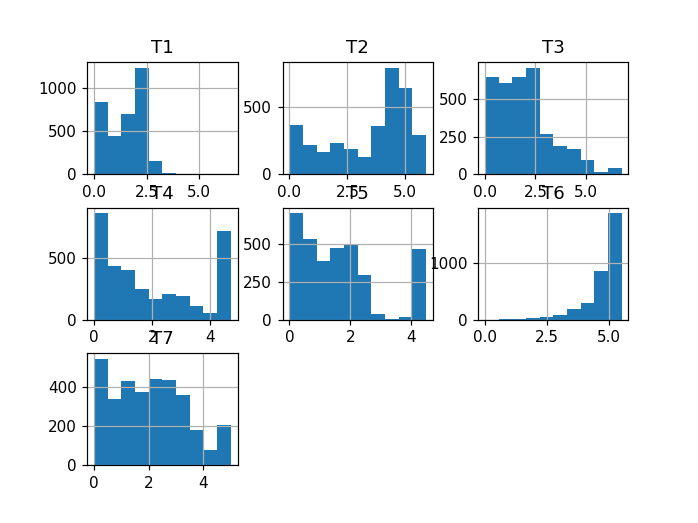

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e24d390>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e3669d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e1d63d0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e228410>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e211750>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e108e90>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e13e750>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e0f2a50>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e0fc4d0>]], dtype=object)

In [48]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [204]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.max()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

In [205]:
output_scaling

sys_states   tank_press         T3        1.713598
                                T1        0.767135
                                T7        2.934528
                                T6        1.510512
                                T5        1.754637
                                T2        1.238836
                                T4        2.719155
aux_outputs  pump_energy        PU2     395.495848
                                PU5     205.421094
                                PU6     345.522009
                                PU8     222.014888
                                PU10    128.847500
             jun_cl_press_mean  0         5.226435
                                1         5.162711
                                2         3.775709
                                3         2.252923
                                4         3.633456
                                5         3.916177
                                6         4.281643
                               

### Train / Test Splitting

In [206]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [207]:
X_train.shape

(2364, 56)

# Neural Network

## Create Model

In [209]:
n_layer = 2
n_units = 240
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 56)]              0         
_________________________________________________________________
dense_65 (Dense)             (None, 240)               13680     
_________________________________________________________________
dense_66 (Dense)             (None, 52)                12532     
Total params: 26,212
Trainable params: 26,212
Non-trainable params: 0
_________________________________________________________________


## Train model

In [214]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [215]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=500, 
                    epochs=5000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),)
                    #callbacks=[callback])

Train on 2364 samples, validate on 592 samples
Epoch 1/5000
2364/2364 [==============================] - 1s 263us/sample - loss: 0.2111 - val_loss: 0.0577
Epoch 2/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0505 - val_loss: 0.0587
Epoch 3/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 0.0588 - val_loss: 0.0527
Epoch 4/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0429 - val_loss: 0.0326
Epoch 5/5000
2364/2364 [==============================] - 0s 62us/sample - loss: 0.0293 - val_loss: 0.0291
Epoch 6/5000
2364/2364 [==============================] - 0s 56us/sample - loss: 0.0283 - val_loss: 0.0286
Epoch 7/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0260 - val_loss: 0.0235
Epoch 8/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0212 - val_loss: 0.0206
Epoch 9/5000
2364/2364 [==============================] - 0s 50us/sample - loss: 0.0197 - val_lo

2364/2364 [==============================] - 0s 45us/sample - loss: 0.0047 - val_loss: 0.0050
Epoch 77/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0047 - val_loss: 0.0050
Epoch 78/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0046 - val_loss: 0.0049
Epoch 79/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0046 - val_loss: 0.0049
Epoch 80/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0046 - val_loss: 0.0049
Epoch 81/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0046 - val_loss: 0.0049
Epoch 82/5000
2364/2364 [==============================] - 0s 52us/sample - loss: 0.0045 - val_loss: 0.0049
Epoch 83/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0045 - val_loss: 0.0049
Epoch 84/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 0.0044 - val_loss: 0.0048
Epoch 85/5000
2364/2364 [=================

2364/2364 [==============================] - 0s 33us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 152/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 153/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 154/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 155/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 156/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 157/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 158/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 159/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0036 - val_loss: 0.0039
Epoch 160/5000
2364/2364 [========

2364/2364 [==============================] - 0s 41us/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 227/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 228/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 229/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 230/5000
2364/2364 [==============================] - 0s 27us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 231/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 232/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 233/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 234/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0035 - val_loss: 0.0039
Epoch 235/5000
2364/2364 [========

2364/2364 [==============================] - 0s 41us/sample - loss: 0.0033 - val_loss: 0.0035
Epoch 302/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 303/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 304/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 305/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 306/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0033 - val_loss: 0.0035
Epoch 307/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 308/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 309/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0033 - val_loss: 0.0037
Epoch 310/5000
2364/2364 [========

2364/2364 [==============================] - 0s 33us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 377/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 378/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 379/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 380/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 381/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 382/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 383/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 384/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 385/5000
2364/2364 [========

2364/2364 [==============================] - 0s 58us/sample - loss: 0.0029 - val_loss: 0.0032
Epoch 452/5000
2364/2364 [==============================] - 0s 55us/sample - loss: 0.0029 - val_loss: 0.0032
Epoch 453/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 0.0029 - val_loss: 0.0031
Epoch 454/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 0.0028 - val_loss: 0.0031
Epoch 455/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0028 - val_loss: 0.0031
Epoch 456/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0028 - val_loss: 0.0032
Epoch 457/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0028 - val_loss: 0.0031
Epoch 458/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0028 - val_loss: 0.0031
Epoch 459/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0028 - val_loss: 0.0031
Epoch 460/5000
2364/2364 [========

2364/2364 [==============================] - 0s 30us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 527/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 528/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 529/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 530/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 531/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 532/5000
2364/2364 [==============================] - 0s 54us/sample - loss: 0.0026 - val_loss: 0.0028
Epoch 533/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0025 - val_loss: 0.0028
Epoch 534/5000
2364/2364 [==============================] - 0s 51us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 535/5000
2364/2364 [========

2364/2364 [==============================] - 0s 31us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 602/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0024 - val_loss: 0.0027
Epoch 603/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 604/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 0.0024 - val_loss: 0.0027
Epoch 605/5000
2364/2364 [==============================] - 0s 50us/sample - loss: 0.0024 - val_loss: 0.0027
Epoch 606/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 607/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 608/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 609/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 610/5000
2364/2364 [========

2364/2364 [==============================] - 0s 29us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 677/5000
2364/2364 [==============================] - 0s 37us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 678/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 679/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 680/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 681/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 682/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 683/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 684/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 685/5000
2364/2364 [========

2364/2364 [==============================] - 0s 41us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 752/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0021 - val_loss: 0.0024
Epoch 753/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 754/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0021 - val_loss: 0.0024
Epoch 755/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 756/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 757/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 758/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 759/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 760/5000
2364/2364 [========

2364/2364 [==============================] - 0s 42us/sample - loss: 0.0020 - val_loss: 0.0023
Epoch 827/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 828/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 829/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 830/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0020 - val_loss: 0.0023
Epoch 831/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0020 - val_loss: 0.0023
Epoch 832/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 0.0020 - val_loss: 0.0023
Epoch 833/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 834/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 835/5000
2364/2364 [========

2364/2364 [==============================] - 0s 30us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 902/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 903/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 904/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 905/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0019 - val_loss: 0.0022
Epoch 906/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 907/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 908/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0019 - val_loss: 0.0022
Epoch 909/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 910/5000
2364/2364 [========

2364/2364 [==============================] - 0s 48us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 977/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 978/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0018 - val_loss: 0.0021
Epoch 979/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 980/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 981/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 982/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 983/5000
2364/2364 [==============================] - 0s 37us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 984/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 985/5000
2364/2364 [========

Epoch 1051/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 1052/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 1053/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 1054/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 0.0017 - val_loss: 0.0020
Epoch 1055/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 1056/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 1057/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 1058/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 1059/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 1060

2364/2364 [==============================] - 0s 31us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 1126/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 1127/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 1128/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 1129/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 1130/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 1131/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1132/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1133/5000
2364/2364 [==============================] - 0s 50us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 1134/5000
2364/2364 

2364/2364 [==============================] - 0s 35us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1200/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1201/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1202/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1203/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1204/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1205/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1206/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1207/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 1208/5000
2364/2364 

2364/2364 [==============================] - 0s 32us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 1274/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1275/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1276/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1277/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1278/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1279/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1280/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 1281/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0016 - val_loss: 0.0019
Epoch 1282/5000
2364/2364 

2364/2364 [==============================] - 0s 44us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1348/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1349/5000
2364/2364 [==============================] - 0s 50us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1350/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1351/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1352/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1353/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1354/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1355/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1356/5000
2364/2364 

2364/2364 [==============================] - 0s 42us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1422/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1423/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 1424/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1425/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1426/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1427/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1428/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1429/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1430/5000
2364/2364 

2364/2364 [==============================] - 0s 45us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1496/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1497/5000
2364/2364 [==============================] - 0s 89us/sample - loss: 0.0014 - val_loss: 0.0018
Epoch 1498/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1499/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1500/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1501/5000
2364/2364 [==============================] - 0s 84us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1502/5000
2364/2364 [==============================] - 0s 54us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1503/5000
2364/2364 [==============================] - 0s 54us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1504/5000
2364/2364 

2364/2364 [==============================] - 0s 31us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1570/5000
2364/2364 [==============================] - 0s 38us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1571/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1572/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1573/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1574/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1575/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1576/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 1577/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 1578/5000
2364/2364 

2364/2364 [==============================] - 0s 35us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1644/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1645/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1646/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1647/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1648/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1649/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1650/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1651/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1652/5000
2364/2364 

2364/2364 [==============================] - 0s 32us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1718/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1719/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1720/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1721/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1722/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1723/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1724/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1725/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1726/5000
2364/2364 

2364/2364 [==============================] - 0s 32us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 1792/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1793/5000
2364/2364 [==============================] - 0s 38us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1794/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1795/5000
2364/2364 [==============================] - 0s 55us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1796/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1797/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 1798/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1799/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1800/5000
2364/2364 

2364/2364 [==============================] - 0s 36us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1866/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1867/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1868/5000
2364/2364 [==============================] - 0s 37us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1869/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1870/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1871/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1872/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1873/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 1874/5000
2364/2364 

2364/2364 [==============================] - 0s 35us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 1940/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 1941/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1942/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 1943/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1944/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1945/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1946/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 1947/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1948/5000
2364/2364 

2364/2364 [==============================] - 0s 30us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2014/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2015/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2016/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 2017/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 2018/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2019/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2020/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2021/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2022/5000
2364/2364 

2364/2364 [==============================] - 0s 46us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2088/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2089/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 2090/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2091/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 2092/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2093/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2094/5000
2364/2364 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2095/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2096/5000
2364/2364 

2364/2364 [==============================] - 0s 47us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2162/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2163/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2164/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2165/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2166/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2167/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2168/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 2169/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 2170/5000
2364/2364 

2364/2364 [==============================] - 0s 58us/sample - loss: 0.0015 - val_loss: 0.0013
Epoch 2236/5000
2364/2364 [==============================] - 0s 66us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 2237/5000
2364/2364 [==============================] - 0s 54us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2238/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2239/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 2240/5000
2364/2364 [==============================] - 0s 59us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2241/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2242/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2243/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2244/5000
2364/2364 

2364/2364 [==============================] - 0s 33us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2310/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2311/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2312/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 2313/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 2314/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2315/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2316/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2317/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2318/5000
2364/2364 

2364/2364 [==============================] - 0s 29us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2384/5000
2364/2364 [==============================] - 0s 38us/sample - loss: 9.9591e-04 - val_loss: 0.0011
Epoch 2385/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 9.9788e-04 - val_loss: 0.0011
Epoch 2386/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2387/5000
2364/2364 [==============================] - 0s 67us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2388/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 2389/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2390/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2391/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 2392/5000
23

2364/2364 [==============================] - 0s 44us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2458/5000
2364/2364 [==============================] - 0s 51us/sample - loss: 0.0010 - val_loss: 0.0014
Epoch 2459/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2460/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2461/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 0.0010 - val_loss: 0.0014
Epoch 2462/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2463/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2464/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2465/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 9.9533e-04 - val_loss: 0.0011
Epoch 2466/5000
2364/2

2364/2364 [==============================] - 0s 48us/sample - loss: 9.8337e-04 - val_loss: 0.0011
Epoch 2531/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2532/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2533/5000
2364/2364 [==============================] - 0s 53us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 2534/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2535/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2536/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2537/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 9.9252e-04 - val_loss: 0.0010
Epoch 2538/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 9.7065e-04 - val_loss: 0.0011
Epoch 2539/500

2364/2364 [==============================] - 0s 44us/sample - loss: 9.6765e-04 - val_loss: 0.0010
Epoch 2604/5000
2364/2364 [==============================] - 0s 50us/sample - loss: 9.5097e-04 - val_loss: 0.0011
Epoch 2605/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 9.4173e-04 - val_loss: 0.0010
Epoch 2606/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 9.6178e-04 - val_loss: 0.0010
Epoch 2607/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 9.4706e-04 - val_loss: 0.0013
Epoch 2608/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 2609/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2610/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2611/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 9.5773e-04 - val_loss: 0.0011
Ep

2364/2364 [==============================] - 0s 41us/sample - loss: 0.0010 - val_loss: 0.0010
Epoch 2676/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 9.4766e-04 - val_loss: 0.0010
Epoch 2677/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 9.4932e-04 - val_loss: 0.0011
Epoch 2678/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 9.6010e-04 - val_loss: 0.0011
Epoch 2679/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 2680/5000
2364/2364 [==============================] - 0s 59us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 2681/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 2682/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 9.7912e-04 - val_loss: 0.0010
Epoch 2683/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 9.3881e-04 - val_loss: 0.0010
Epoch 

2364/2364 [==============================] - 0s 33us/sample - loss: 9.0429e-04 - val_loss: 0.0010
Epoch 2748/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 9.0448e-04 - val_loss: 0.0011
Epoch 2749/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 0.0010 - val_loss: 0.0010
Epoch 2750/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 9.3706e-04 - val_loss: 0.0010
Epoch 2751/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 9.0906e-04 - val_loss: 0.0010
Epoch 2752/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 9.3144e-04 - val_loss: 0.0010
Epoch 2753/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 9.1376e-04 - val_loss: 9.9565e-04
Epoch 2754/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 9.3256e-04 - val_loss: 0.0010
Epoch 2755/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 9.2908e-04 - val_los

Epoch 2819/5000
2364/2364 [==============================] - 0s 55us/sample - loss: 9.0798e-04 - val_loss: 9.8434e-04
Epoch 2820/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 8.8878e-04 - val_loss: 0.0011
Epoch 2821/5000
2364/2364 [==============================] - 0s 50us/sample - loss: 9.8341e-04 - val_loss: 0.0012
Epoch 2822/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 9.7715e-04 - val_loss: 0.0010
Epoch 2823/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 9.3207e-04 - val_loss: 0.0011
Epoch 2824/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 9.6788e-04 - val_loss: 0.0010
Epoch 2825/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 9.5601e-04 - val_loss: 0.0011
Epoch 2826/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 9.4117e-04 - val_loss: 0.0011
Epoch 2827/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 

2364/2364 [==============================] - 0s 35us/sample - loss: 8.8444e-04 - val_loss: 9.7851e-04
Epoch 2891/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.9544e-04 - val_loss: 9.8714e-04
Epoch 2892/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 8.7435e-04 - val_loss: 9.8723e-04
Epoch 2893/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.7923e-04 - val_loss: 9.7023e-04
Epoch 2894/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 9.1620e-04 - val_loss: 0.0010
Epoch 2895/5000
2364/2364 [==============================] - 0s 38us/sample - loss: 9.3314e-04 - val_loss: 0.0010
Epoch 2896/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 9.3381e-04 - val_loss: 0.0011
Epoch 2897/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 9.5760e-04 - val_loss: 0.0011
Epoch 2898/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 9.95

2364/2364 [==============================] - 0s 42us/sample - loss: 9.7997e-04 - val_loss: 9.9395e-04
Epoch 2962/5000
2364/2364 [==============================] - 0s 52us/sample - loss: 9.0908e-04 - val_loss: 0.0010
Epoch 2963/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 8.9320e-04 - val_loss: 0.0011
Epoch 2964/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 9.6116e-04 - val_loss: 9.6888e-04
Epoch 2965/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 9.1373e-04 - val_loss: 0.0010
Epoch 2966/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 9.0733e-04 - val_loss: 0.0010
Epoch 2967/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.9071e-04 - val_loss: 0.0011
Epoch 2968/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 9.4407e-04 - val_loss: 9.7427e-04
Epoch 2969/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 8.9828e-

Epoch 3032/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 9.3504e-04 - val_loss: 9.4683e-04
Epoch 3033/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.7344e-04 - val_loss: 0.0011
Epoch 3034/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.8512e-04 - val_loss: 9.3990e-04
Epoch 3035/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.6599e-04 - val_loss: 9.6644e-04
Epoch 3036/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.6121e-04 - val_loss: 0.0010
Epoch 3037/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.7935e-04 - val_loss: 9.4251e-04
Epoch 3038/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.6712e-04 - val_loss: 0.0010
Epoch 3039/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.8127e-04 - val_loss: 9.7353e-04
Epoch 3040/5000
2364/2364 [==============================] - 0s 29us

2364/2364 [==============================] - 0s 44us/sample - loss: 9.3170e-04 - val_loss: 0.0011
Epoch 3103/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 9.2814e-04 - val_loss: 0.0010
Epoch 3104/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 8.6217e-04 - val_loss: 9.3996e-04
Epoch 3105/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 8.4689e-04 - val_loss: 9.6181e-04
Epoch 3106/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 8.6665e-04 - val_loss: 9.5291e-04
Epoch 3107/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 8.5823e-04 - val_loss: 0.0011
Epoch 3108/5000
2364/2364 [==============================] - 0s 49us/sample - loss: 9.3925e-04 - val_loss: 9.6914e-04
Epoch 3109/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 9.2396e-04 - val_loss: 0.0012
Epoch 3110/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 0.00

2364/2364 [==============================] - 0s 30us/sample - loss: 8.8010e-04 - val_loss: 0.0010
Epoch 3173/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 8.8331e-04 - val_loss: 9.7679e-04
Epoch 3174/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.7632e-04 - val_loss: 9.8879e-04
Epoch 3175/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.4026e-04 - val_loss: 9.3848e-04
Epoch 3176/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 8.6112e-04 - val_loss: 9.5121e-04
Epoch 3177/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 8.3975e-04 - val_loss: 0.0010
Epoch 3178/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.7423e-04 - val_loss: 9.3311e-04
Epoch 3179/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 8.3879e-04 - val_loss: 9.8499e-04
Epoch 3180/5000
2364/2364 [==============================] - 0s 29us/sample - lo

2364/2364 [==============================] - 0s 38us/sample - loss: 8.6409e-04 - val_loss: 9.1841e-04
Epoch 3243/5000
2364/2364 [==============================] - 0s 37us/sample - loss: 8.2635e-04 - val_loss: 0.0010
Epoch 3244/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.8413e-04 - val_loss: 0.0010
Epoch 3245/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.6535e-04 - val_loss: 9.2553e-04
Epoch 3246/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.9970e-04 - val_loss: 0.0011
Epoch 3247/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 9.5105e-04 - val_loss: 9.7725e-04
Epoch 3248/5000
2364/2364 [==============================] - 0s 38us/sample - loss: 8.8813e-04 - val_loss: 0.0010
Epoch 3249/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 8.7427e-04 - val_loss: 9.5178e-04
Epoch 3250/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 8.28

2364/2364 [==============================] - 0s 33us/sample - loss: 8.8290e-04 - val_loss: 9.0516e-04
Epoch 3313/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 8.5331e-04 - val_loss: 9.7057e-04
Epoch 3314/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 8.5022e-04 - val_loss: 9.5890e-04
Epoch 3315/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.9609e-04 - val_loss: 9.3651e-04
Epoch 3316/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.7717e-04 - val_loss: 9.6697e-04
Epoch 3317/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.2481e-04 - val_loss: 9.7749e-04
Epoch 3318/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 8.5198e-04 - val_loss: 0.0011
Epoch 3319/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.8754e-04 - val_loss: 9.5981e-04
Epoch 3320/5000
2364/2364 [==============================] - 0s 30us/sample 

2364/2364 [==============================] - 0s 34us/sample - loss: 8.6165e-04 - val_loss: 9.0445e-04
Epoch 3383/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 9.4152e-04 - val_loss: 0.0010
Epoch 3384/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 8.5945e-04 - val_loss: 0.0010
Epoch 3385/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.4607e-04 - val_loss: 9.2506e-04
Epoch 3386/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.5318e-04 - val_loss: 9.1997e-04
Epoch 3387/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.6517e-04 - val_loss: 0.0010
Epoch 3388/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.4990e-04 - val_loss: 9.4550e-04
Epoch 3389/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.1914e-04 - val_loss: 9.3399e-04
Epoch 3390/5000
2364/2364 [==============================] - 0s 37us/sample - loss: 

2364/2364 [==============================] - 0s 42us/sample - loss: 7.8883e-04 - val_loss: 9.1129e-04
Epoch 3453/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 7.9777e-04 - val_loss: 8.8794e-04
Epoch 3454/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 7.8895e-04 - val_loss: 9.2714e-04
Epoch 3455/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.1341e-04 - val_loss: 9.0553e-04
Epoch 3456/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.1642e-04 - val_loss: 8.8394e-04
Epoch 3457/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 7.9318e-04 - val_loss: 8.9735e-04
Epoch 3458/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 7.9139e-04 - val_loss: 9.3015e-04
Epoch 3459/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.0428e-04 - val_loss: 8.9110e-04
Epoch 3460/5000
2364/2364 [==============================] - 0s 33us/sam

2364/2364 [==============================] - 0s 44us/sample - loss: 8.5730e-04 - val_loss: 9.6686e-04
Epoch 3523/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 8.4884e-04 - val_loss: 9.0370e-04
Epoch 3524/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 7.9081e-04 - val_loss: 9.3525e-04
Epoch 3525/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 8.0314e-04 - val_loss: 8.8310e-04
Epoch 3526/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 7.7387e-04 - val_loss: 8.9505e-04
Epoch 3527/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 7.7286e-04 - val_loss: 9.4597e-04
Epoch 3528/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 8.0778e-04 - val_loss: 8.9006e-04
Epoch 3529/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 8.0357e-04 - val_loss: 9.2875e-04
Epoch 3530/5000
2364/2364 [==============================] - 0s 45us/sam

Epoch 3592/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.8484e-04 - val_loss: 8.7697e-04
Epoch 3593/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 7.6284e-04 - val_loss: 8.7069e-04
Epoch 3594/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.8709e-04 - val_loss: 8.7280e-04
Epoch 3595/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.7113e-04 - val_loss: 9.0365e-04
Epoch 3596/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 7.9094e-04 - val_loss: 9.1134e-04
Epoch 3597/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.0571e-04 - val_loss: 8.9276e-04
Epoch 3598/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.1194e-04 - val_loss: 0.0010
Epoch 3599/5000
2364/2364 [==============================] - 0s 36us/sample - loss: 8.7160e-04 - val_loss: 9.2977e-04
Epoch 3600/5000
2364/2364 [==============================] -

2364/2364 [==============================] - 0s 33us/sample - loss: 8.2896e-04 - val_loss: 8.7570e-04
Epoch 3662/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 7.8253e-04 - val_loss: 9.2301e-04
Epoch 3663/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.9049e-04 - val_loss: 8.7557e-04
Epoch 3664/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.0600e-04 - val_loss: 0.0010
Epoch 3665/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 8.4435e-04 - val_loss: 9.1534e-04
Epoch 3666/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 7.9982e-04 - val_loss: 9.4697e-04
Epoch 3667/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 8.1665e-04 - val_loss: 9.7129e-04
Epoch 3668/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 7.9612e-04 - val_loss: 8.5252e-04
Epoch 3669/5000
2364/2364 [==============================] - 0s 44us/sample 

Epoch 3731/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.9633e-04 - val_loss: 8.9409e-04
Epoch 3732/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 8.1222e-04 - val_loss: 0.0010
Epoch 3733/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 8.6203e-04 - val_loss: 0.0011
Epoch 3734/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 8.4294e-04 - val_loss: 8.9436e-04
Epoch 3735/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 7.8326e-04 - val_loss: 8.6013e-04
Epoch 3736/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.8658e-04 - val_loss: 9.6040e-04
Epoch 3737/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 7.9460e-04 - val_loss: 9.1984e-04
Epoch 3738/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 8.0430e-04 - val_loss: 0.0011
Epoch 3739/5000
2364/2364 [==============================] - 0s 34us

Epoch 3801/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.8673e-04 - val_loss: 0.0010
Epoch 3802/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 8.1523e-04 - val_loss: 9.5048e-04
Epoch 3803/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 8.4252e-04 - val_loss: 8.4350e-04
Epoch 3804/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.8669e-04 - val_loss: 8.7609e-04
Epoch 3805/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.5142e-04 - val_loss: 8.8198e-04
Epoch 3806/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.6393e-04 - val_loss: 8.6402e-04
Epoch 3807/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 7.8304e-04 - val_loss: 8.6638e-04
Epoch 3808/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 7.6511e-04 - val_loss: 8.7691e-04
Epoch 3809/5000
2364/2364 [==============================] -

2364/2364 [==============================] - 0s 48us/sample - loss: 7.6950e-04 - val_loss: 9.5789e-04
Epoch 3871/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 8.6541e-04 - val_loss: 8.6193e-04
Epoch 3872/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 7.8779e-04 - val_loss: 9.8771e-04
Epoch 3873/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 8.2897e-04 - val_loss: 8.9579e-04
Epoch 3874/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 8.0687e-04 - val_loss: 9.3453e-04
Epoch 3875/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 8.2076e-04 - val_loss: 8.9748e-04
Epoch 3876/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 7.8634e-04 - val_loss: 8.5846e-04
Epoch 3877/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 7.7260e-04 - val_loss: 9.0757e-04
Epoch 3878/5000
2364/2364 [==============================] - 0s 40us/sam

2364/2364 [==============================] - 0s 44us/sample - loss: 7.9834e-04 - val_loss: 8.3191e-04
Epoch 3940/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 7.9788e-04 - val_loss: 9.3903e-04
Epoch 3941/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 7.9587e-04 - val_loss: 8.8915e-04
Epoch 3942/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 7.7080e-04 - val_loss: 8.5670e-04
Epoch 3943/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 7.5218e-04 - val_loss: 8.4471e-04
Epoch 3944/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 8.1057e-04 - val_loss: 9.6608e-04
Epoch 3945/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 8.4676e-04 - val_loss: 9.2827e-04
Epoch 3946/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 8.1625e-04 - val_loss: 0.0010
Epoch 3947/5000
2364/2364 [==============================] - 0s 46us/sample 

2364/2364 [==============================] - 0s 36us/sample - loss: 8.0157e-04 - val_loss: 0.0013
Epoch 4009/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 9.3951e-04 - val_loss: 9.0504e-04
Epoch 4010/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 9.1345e-04 - val_loss: 0.0010
Epoch 4011/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 9.8416e-04 - val_loss: 9.9829e-04
Epoch 4012/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 8.5183e-04 - val_loss: 8.4356e-04
Epoch 4013/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.4572e-04 - val_loss: 8.4107e-04
Epoch 4014/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.3330e-04 - val_loss: 8.4006e-04
Epoch 4015/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.2206e-04 - val_loss: 8.6332e-04
Epoch 4016/5000
2364/2364 [==============================] - 0s 29us/sample - lo

Epoch 4078/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.6107e-04 - val_loss: 8.8725e-04
Epoch 4079/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.1845e-04 - val_loss: 8.3484e-04
Epoch 4080/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.3279e-04 - val_loss: 8.4099e-04
Epoch 4081/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.4025e-04 - val_loss: 8.5740e-04
Epoch 4082/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.3058e-04 - val_loss: 8.5810e-04
Epoch 4083/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.2657e-04 - val_loss: 8.4440e-04
Epoch 4084/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 7.2703e-04 - val_loss: 8.5405e-04
Epoch 4085/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 7.3580e-04 - val_loss: 8.7390e-04
Epoch 4086/5000
2364/2364 [=============================

2364/2364 [==============================] - 0s 38us/sample - loss: 7.4684e-04 - val_loss: 9.6307e-04
Epoch 4148/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 7.7831e-04 - val_loss: 9.4529e-04
Epoch 4149/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 7.5157e-04 - val_loss: 8.2360e-04
Epoch 4150/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 7.1696e-04 - val_loss: 8.3397e-04
Epoch 4151/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 7.4497e-04 - val_loss: 8.2413e-04
Epoch 4152/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 7.2810e-04 - val_loss: 8.2149e-04
Epoch 4153/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 7.0200e-04 - val_loss: 8.0831e-04
Epoch 4154/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.0011e-04 - val_loss: 8.6681e-04
Epoch 4155/5000
2364/2364 [==============================] - 0s 33us/sam

2364/2364 [==============================] - 0s 29us/sample - loss: 7.2702e-04 - val_loss: 9.1483e-04
Epoch 4217/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.5458e-04 - val_loss: 9.1891e-04
Epoch 4218/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 7.4498e-04 - val_loss: 8.2020e-04
Epoch 4219/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.6556e-04 - val_loss: 9.2353e-04
Epoch 4220/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.9664e-04 - val_loss: 8.9541e-04
Epoch 4221/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.6185e-04 - val_loss: 8.8193e-04
Epoch 4222/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.4419e-04 - val_loss: 9.0820e-04
Epoch 4223/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.7303e-04 - val_loss: 8.2318e-04
Epoch 4224/5000
2364/2364 [==============================] - 0s 30us/sam

2364/2364 [==============================] - 0s 44us/sample - loss: 7.2093e-04 - val_loss: 8.9166e-04
Epoch 4286/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 7.3339e-04 - val_loss: 8.9613e-04
Epoch 4287/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.3287e-04 - val_loss: 8.1411e-04
Epoch 4288/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.3790e-04 - val_loss: 8.6414e-04
Epoch 4289/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.4340e-04 - val_loss: 8.6382e-04
Epoch 4290/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 7.2245e-04 - val_loss: 8.0877e-04
Epoch 4291/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.0626e-04 - val_loss: 8.2150e-04
Epoch 4292/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.4619e-04 - val_loss: 8.7491e-04
Epoch 4293/5000
2364/2364 [==============================] - 0s 30us/sam

2364/2364 [==============================] - 0s 34us/sample - loss: 7.1399e-04 - val_loss: 8.4812e-04
Epoch 4355/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.2384e-04 - val_loss: 8.0372e-04
Epoch 4356/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.0449e-04 - val_loss: 8.4247e-04
Epoch 4357/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 7.2047e-04 - val_loss: 8.1106e-04
Epoch 4358/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 7.1902e-04 - val_loss: 8.5678e-04
Epoch 4359/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 7.7655e-04 - val_loss: 9.2280e-04
Epoch 4360/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.0992e-04 - val_loss: 8.8088e-04
Epoch 4361/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.2336e-04 - val_loss: 9.3265e-04
Epoch 4362/5000
2364/2364 [==============================] - 0s 29us/sam

Epoch 4424/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 7.3832e-04 - val_loss: 8.0741e-04
Epoch 4425/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.1480e-04 - val_loss: 7.9712e-04
Epoch 4426/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 6.9270e-04 - val_loss: 8.0273e-04
Epoch 4427/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 6.9085e-04 - val_loss: 8.1650e-04
Epoch 4428/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 6.9734e-04 - val_loss: 8.3393e-04
Epoch 4429/5000
2364/2364 [==============================] - 0s 28us/sample - loss: 7.2409e-04 - val_loss: 9.6980e-04
Epoch 4430/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.6182e-04 - val_loss: 9.3828e-04
Epoch 4431/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.5931e-04 - val_loss: 8.7969e-04
Epoch 4432/5000
2364/2364 [=============================

2364/2364 [==============================] - 0s 53us/sample - loss: 7.1211e-04 - val_loss: 8.5872e-04
Epoch 4494/5000
2364/2364 [==============================] - 0s 45us/sample - loss: 6.9719e-04 - val_loss: 7.8557e-04
Epoch 4495/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 7.1859e-04 - val_loss: 9.0295e-04
Epoch 4496/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 7.6446e-04 - val_loss: 7.9226e-04
Epoch 4497/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.2988e-04 - val_loss: 8.1738e-04
Epoch 4498/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 6.9577e-04 - val_loss: 9.6869e-04
Epoch 4499/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.7146e-04 - val_loss: 9.5973e-04
Epoch 4500/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.4286e-04 - val_loss: 7.8934e-04
Epoch 4501/5000
2364/2364 [==============================] - 0s 33us/sam

2364/2364 [==============================] - 0s 46us/sample - loss: 7.6662e-04 - val_loss: 7.8176e-04
Epoch 4563/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 7.1679e-04 - val_loss: 9.6034e-04
Epoch 4564/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 8.6227e-04 - val_loss: 0.0012
Epoch 4565/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 8.5486e-04 - val_loss: 8.3942e-04
Epoch 4566/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 7.2670e-04 - val_loss: 8.4422e-04
Epoch 4567/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 7.2891e-04 - val_loss: 7.9538e-04
Epoch 4568/5000
2364/2364 [==============================] - 0s 41us/sample - loss: 7.0049e-04 - val_loss: 8.1086e-04
Epoch 4569/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.9615e-04 - val_loss: 9.7696e-04
Epoch 4570/5000
2364/2364 [==============================] - 0s 49us/sample 

2364/2364 [==============================] - 0s 30us/sample - loss: 6.9998e-04 - val_loss: 9.2465e-04
Epoch 4632/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.4808e-04 - val_loss: 9.3573e-04
Epoch 4633/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.2221e-04 - val_loss: 8.1322e-04
Epoch 4634/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.3496e-04 - val_loss: 8.4707e-04
Epoch 4635/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.3241e-04 - val_loss: 7.8286e-04
Epoch 4636/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 6.9643e-04 - val_loss: 9.5333e-04
Epoch 4637/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.2732e-04 - val_loss: 8.1221e-04
Epoch 4638/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 6.8026e-04 - val_loss: 7.7844e-04
Epoch 4639/5000
2364/2364 [==============================] - 0s 33us/sam

2364/2364 [==============================] - 0s 33us/sample - loss: 6.8631e-04 - val_loss: 8.0877e-04
Epoch 4701/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.0973e-04 - val_loss: 8.3094e-04
Epoch 4702/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.1645e-04 - val_loss: 9.7232e-04
Epoch 4703/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.9612e-04 - val_loss: 8.1472e-04
Epoch 4704/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.0185e-04 - val_loss: 8.7307e-04
Epoch 4705/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 7.2287e-04 - val_loss: 8.9370e-04
Epoch 4706/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.2262e-04 - val_loss: 8.7887e-04
Epoch 4707/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 6.9863e-04 - val_loss: 8.7314e-04
Epoch 4708/5000
2364/2364 [==============================] - 0s 30us/sam

2364/2364 [==============================] - 0s 44us/sample - loss: 6.7106e-04 - val_loss: 7.7515e-04
Epoch 4770/5000
2364/2364 [==============================] - 0s 47us/sample - loss: 6.6507e-04 - val_loss: 8.0218e-04
Epoch 4771/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.8238e-04 - val_loss: 7.8446e-04
Epoch 4772/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.6748e-04 - val_loss: 7.9751e-04
Epoch 4773/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.9627e-04 - val_loss: 8.0322e-04
Epoch 4774/5000
2364/2364 [==============================] - 0s 44us/sample - loss: 6.7627e-04 - val_loss: 8.0010e-04
Epoch 4775/5000
2364/2364 [==============================] - 0s 46us/sample - loss: 7.3018e-04 - val_loss: 0.0011
Epoch 4776/5000
2364/2364 [==============================] - 0s 40us/sample - loss: 9.1926e-04 - val_loss: 0.0011
Epoch 4777/5000
2364/2364 [==============================] - 0s 43us/sample - lo

2364/2364 [==============================] - 0s 34us/sample - loss: 8.0327e-04 - val_loss: 0.0010
Epoch 4839/5000
2364/2364 [==============================] - 0s 39us/sample - loss: 8.4095e-04 - val_loss: 8.0938e-04
Epoch 4840/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 7.1837e-04 - val_loss: 8.5129e-04
Epoch 4841/5000
2364/2364 [==============================] - 0s 43us/sample - loss: 6.9238e-04 - val_loss: 7.8275e-04
Epoch 4842/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.7390e-04 - val_loss: 7.8428e-04
Epoch 4843/5000
2364/2364 [==============================] - 0s 48us/sample - loss: 6.6045e-04 - val_loss: 7.7498e-04
Epoch 4844/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.4256e-04 - val_loss: 7.6296e-04
Epoch 4845/5000
2364/2364 [==============================] - 0s 42us/sample - loss: 6.7433e-04 - val_loss: 8.8260e-04
Epoch 4846/5000
2364/2364 [==============================] - 0s 44us/sample 

2364/2364 [==============================] - 0s 30us/sample - loss: 6.6465e-04 - val_loss: 7.7510e-04
Epoch 4908/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 6.5871e-04 - val_loss: 7.8317e-04
Epoch 4909/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 6.5550e-04 - val_loss: 7.5849e-04
Epoch 4910/5000
2364/2364 [==============================] - 0s 32us/sample - loss: 6.5000e-04 - val_loss: 8.5836e-04
Epoch 4911/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 6.7795e-04 - val_loss: 7.7437e-04
Epoch 4912/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 6.9039e-04 - val_loss: 8.3323e-04
Epoch 4913/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 7.7411e-04 - val_loss: 8.8749e-04
Epoch 4914/5000
2364/2364 [==============================] - 0s 35us/sample - loss: 7.1906e-04 - val_loss: 8.5897e-04
Epoch 4915/5000
2364/2364 [==============================] - 0s 29us/sam

2364/2364 [==============================] - 0s 34us/sample - loss: 8.6897e-04 - val_loss: 9.9592e-04
Epoch 4977/5000
2364/2364 [==============================] - 0s 37us/sample - loss: 8.5083e-04 - val_loss: 7.9957e-04
Epoch 4978/5000
2364/2364 [==============================] - 0s 30us/sample - loss: 7.3800e-04 - val_loss: 9.1639e-04
Epoch 4979/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 7.3920e-04 - val_loss: 8.0303e-04
Epoch 4980/5000
2364/2364 [==============================] - 0s 29us/sample - loss: 6.6730e-04 - val_loss: 8.0791e-04
Epoch 4981/5000
2364/2364 [==============================] - 0s 34us/sample - loss: 6.5790e-04 - val_loss: 8.0340e-04
Epoch 4982/5000
2364/2364 [==============================] - 0s 33us/sample - loss: 7.0087e-04 - val_loss: 7.9315e-04
Epoch 4983/5000
2364/2364 [==============================] - 0s 31us/sample - loss: 6.6914e-04 - val_loss: 7.8801e-04
Epoch 4984/5000
2364/2364 [==============================] - 0s 38us/sam

Save model:

In [216]:
model_path = './models/'
model_name = '013_man_1x240_only_mpc'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [187]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [188]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [189]:
val_i = -1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [190]:
for k in range(50):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<IPython.core.display.Javascript object>


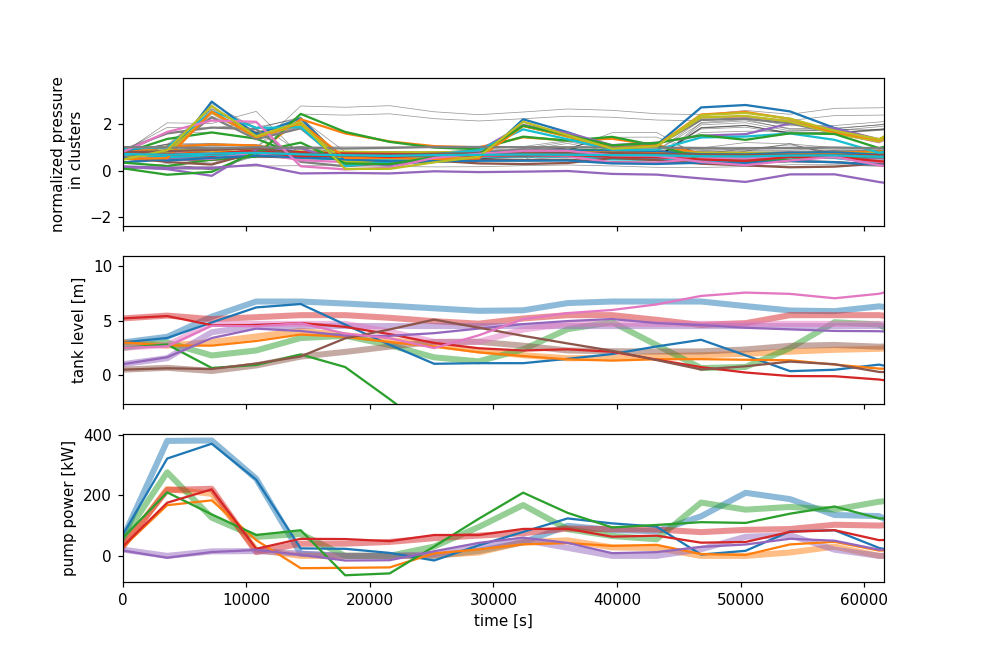

Text(0.5, 0, 'time [s]')

In [191]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [87]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [93]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


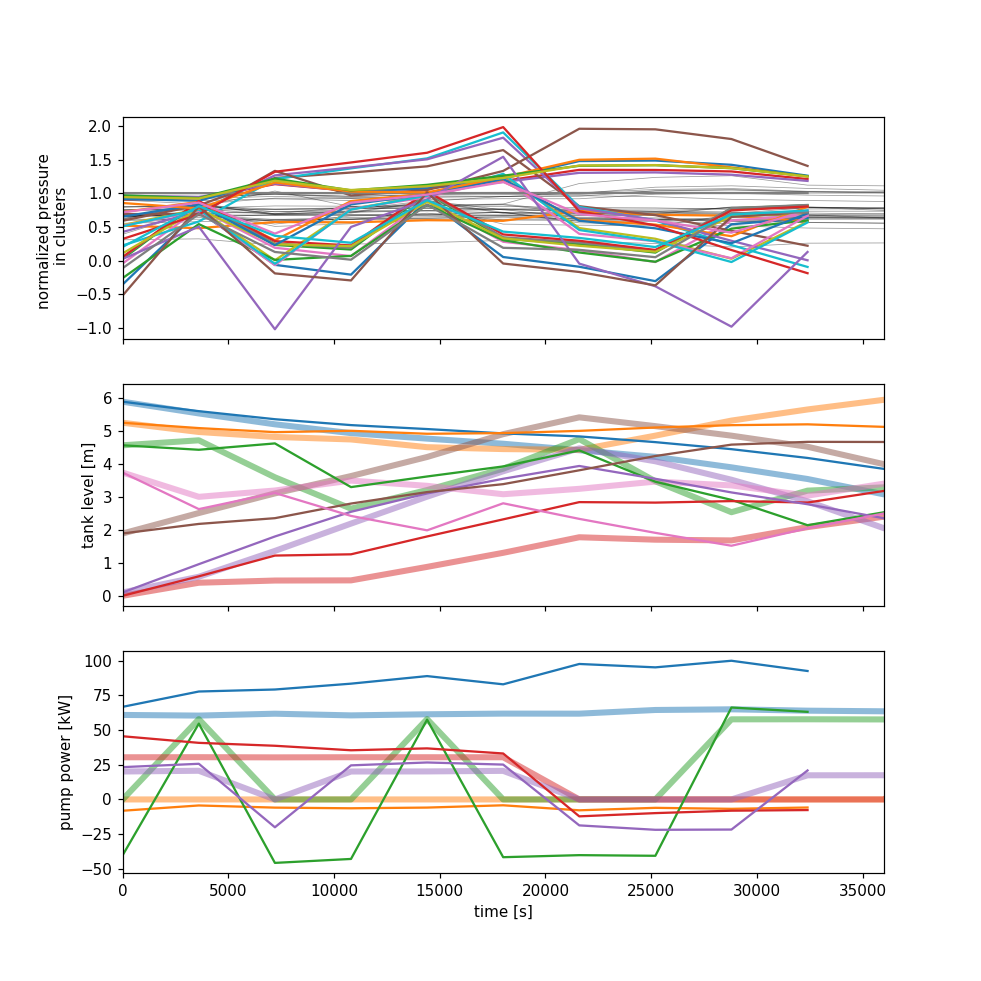

Text(0.5, 0, 'time [s]')

In [94]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')